##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 1s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [4]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

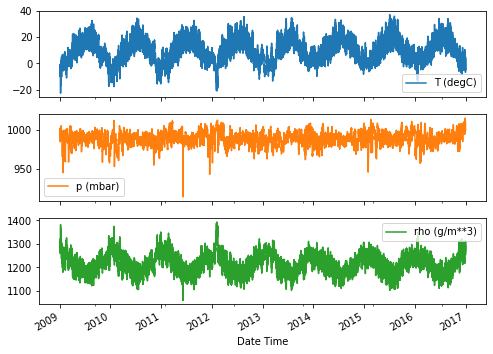

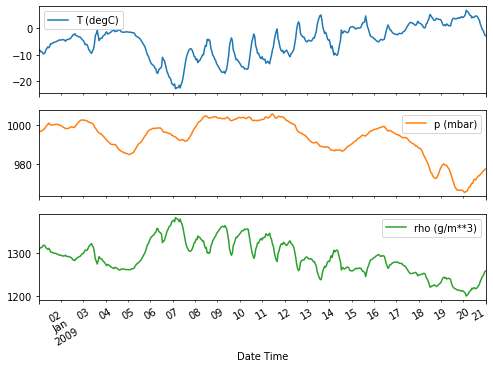

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

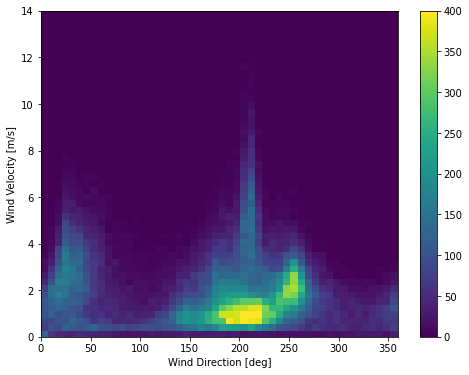

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

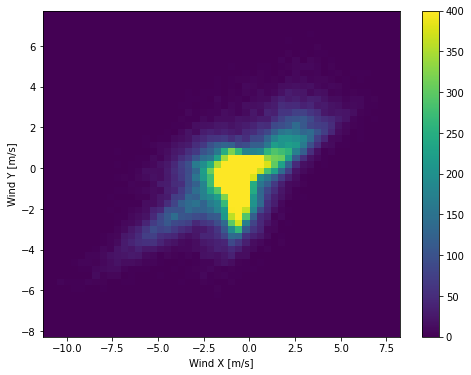

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

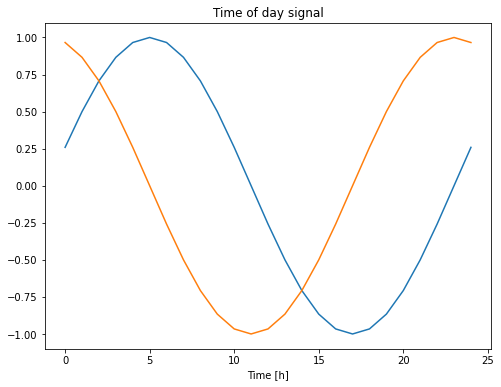

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

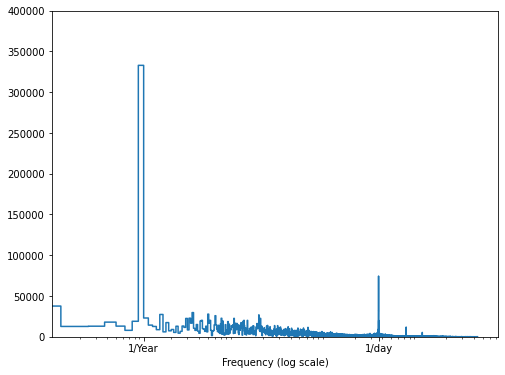

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

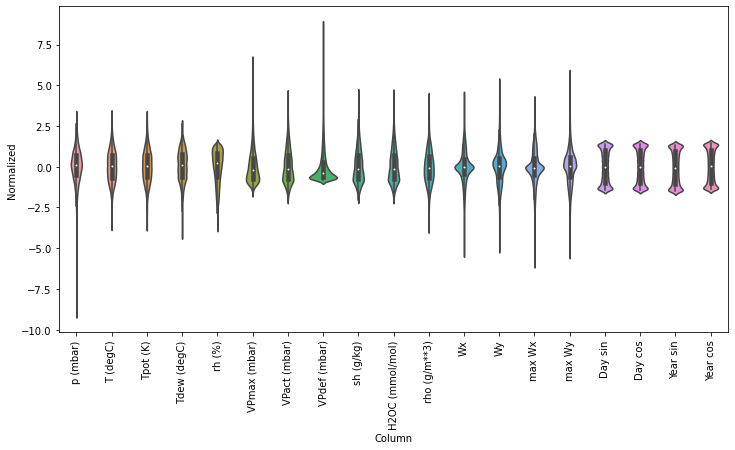

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

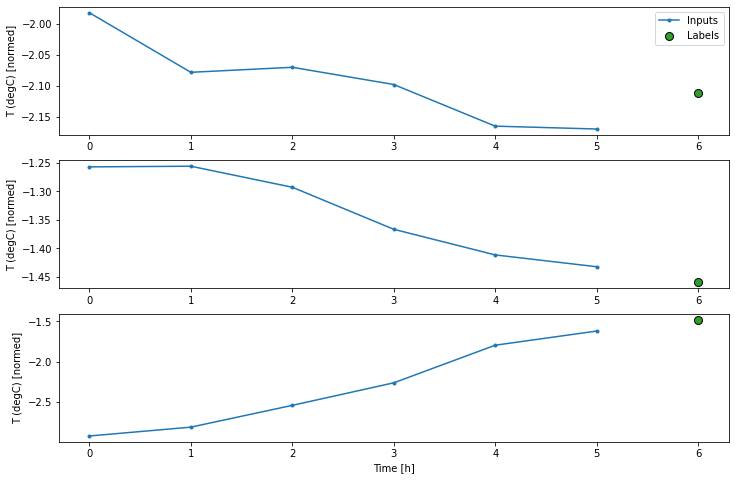

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

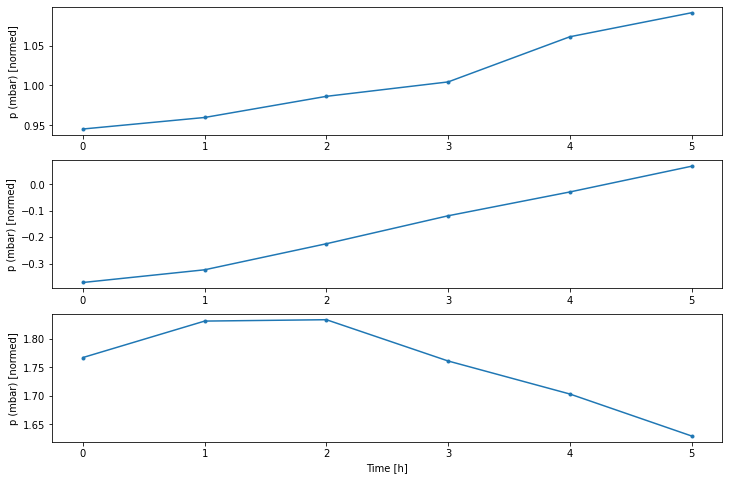

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0903

 26/439 [>.............................] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.0765

 52/439 [==>...........................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0788

 78/439 [====>.........................] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0783

105/439 [======>.......................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0774

133/439 [========>.....................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0773

161/439 [==========>...................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0778

189/439 [===========>..................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0777

216/439 [=============>................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0782

243/439 [===============>..............] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0779

272/439 [=================>............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

301/439 [===================>..........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

329/439 [=====================>........] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0782

356/439 [=======================>......] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0781

383/439 [=========================>....] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0782

409/439 [==========================>...] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0784

434/439 [============================>.] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

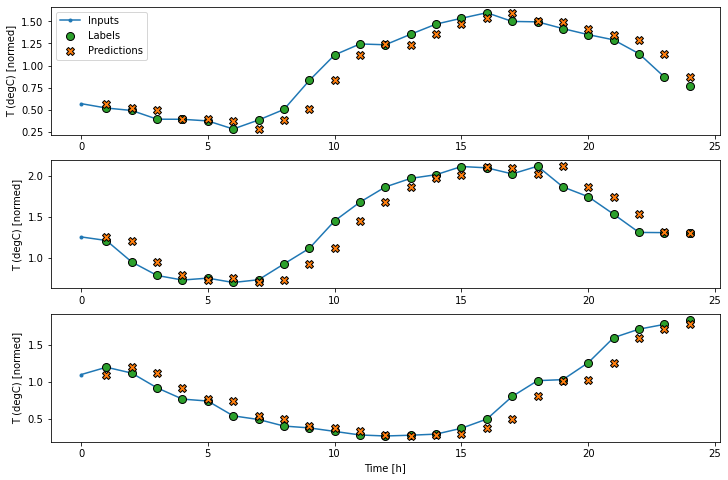

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explaination:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 0s - loss: 4.3325 - mean_absolute_error: 1.6568

  20/1534 [..............................] - ETA: 3s - loss: 3.3822 - mean_absolute_error: 1.4929

  41/1534 [..............................] - ETA: 3s - loss: 2.8342 - mean_absolute_error: 1.3505

  60/1534 [>.............................] - ETA: 3s - loss: 2.5980 - mean_absolute_error: 1.2921

  81/1534 [>.............................] - ETA: 3s - loss: 2.3425 - mean_absolute_error: 1.2236

 101/1534 [>.............................] - ETA: 3s - loss: 2.1568 - mean_absolute_error: 1.1727

 121/1534 [=>............................] - ETA: 3s - loss: 1.9921 - mean_absolute_error: 1.1221

 141/1534 [=>............................] - ETA: 3s - loss: 1.8578 - mean_absolute_error: 1.0798

 161/1534 [==>...........................] - ETA: 3s - loss: 1.7218 - mean_absolute_error: 1.0341

 182/1534 [==>...........................] - ETA: 3s - loss: 1.5971 - mean_absolute_error: 0.9904

 203/1534 [==>...........................] - ETA: 3s - loss: 1.4859 - mean_absolute_error: 0.9478

 224/1534 [===>..........................] - ETA: 3s - loss: 1.3904 - mean_absolute_error: 0.9107

 245/1534 [===>..........................] - ETA: 3s - loss: 1.3068 - mean_absolute_error: 0.8768

 262/1534 [====>.........................] - ETA: 3s - loss: 1.2470 - mean_absolute_error: 0.8519

 282/1534 [====>.........................] - ETA: 3s - loss: 1.1852 - mean_absolute_error: 0.8264

 303/1534 [====>.........................] - ETA: 3s - loss: 1.1251 - mean_absolute_error: 0.8007

 324/1534 [=====>........................] - ETA: 3s - loss: 1.0700 - mean_absolute_error: 0.7763

 345/1534 [=====>........................] - ETA: 2s - loss: 1.0221 - mean_absolute_error: 0.7560

 367/1534 [======>.......................] - ETA: 2s - loss: 0.9766 - mean_absolute_error: 0.7351

 389/1534 [======>.......................] - ETA: 2s - loss: 0.9351 - mean_absolute_error: 0.7158

 408/1534 [======>.......................] - ETA: 2s - loss: 0.9008 - mean_absolute_error: 0.6993

 429/1534 [=======>......................] - ETA: 2s - loss: 0.8671 - mean_absolute_error: 0.6832

 450/1534 [=======>......................] - ETA: 2s - loss: 0.8356 - mean_absolute_error: 0.6679

 471/1534 [========>.....................] - ETA: 2s - loss: 0.8065 - mean_absolute_error: 0.6534

 492/1534 [========>.....................] - ETA: 2s - loss: 0.7793 - mean_absolute_error: 0.6397

 513/1534 [=========>....................] - ETA: 2s - loss: 0.7536 - mean_absolute_error: 0.6261

 534/1534 [=========>....................] - ETA: 2s - loss: 0.7296 - mean_absolute_error: 0.6133

 556/1534 [=========>....................] - ETA: 2s - loss: 0.7064 - mean_absolute_error: 0.6010

 576/1534 [==========>...................] - ETA: 2s - loss: 0.6863 - mean_absolute_error: 0.5900

 597/1534 [==========>...................] - ETA: 2s - loss: 0.6671 - mean_absolute_error: 0.5799

 619/1534 [===========>..................] - ETA: 2s - loss: 0.6479 - mean_absolute_error: 0.5694

 641/1534 [===========>..................] - ETA: 2s - loss: 0.6294 - mean_absolute_error: 0.5588

 661/1534 [===========>..................] - ETA: 2s - loss: 0.6138 - mean_absolute_error: 0.5503

 683/1534 [============>.................] - ETA: 2s - loss: 0.5976 - mean_absolute_error: 0.5411

 704/1534 [============>.................] - ETA: 2s - loss: 0.5829 - mean_absolute_error: 0.5326

 726/1534 [=============>................] - ETA: 1s - loss: 0.5684 - mean_absolute_error: 0.5243

 747/1534 [=============>................] - ETA: 1s - loss: 0.5551 - mean_absolute_error: 0.5164

 769/1534 [==============>...............] - ETA: 1s - loss: 0.5416 - mean_absolute_error: 0.5083

 789/1534 [==============>...............] - ETA: 1s - loss: 0.5301 - mean_absolute_error: 0.5013

 811/1534 [==============>...............] - ETA: 1s - loss: 0.5181 - mean_absolute_error: 0.4941

 832/1534 [===============>..............] - ETA: 1s - loss: 0.5071 - mean_absolute_error: 0.4872

 854/1534 [===============>..............] - ETA: 1s - loss: 0.4959 - mean_absolute_error: 0.4801

 877/1534 [================>.............] - ETA: 1s - loss: 0.4847 - mean_absolute_error: 0.4730

 900/1534 [================>.............] - ETA: 1s - loss: 0.4740 - mean_absolute_error: 0.4662

 923/1534 [=================>............] - ETA: 1s - loss: 0.4637 - mean_absolute_error: 0.4594

 946/1534 [=================>............] - ETA: 1s - loss: 0.4540 - mean_absolute_error: 0.4529

 967/1534 [=================>............] - ETA: 1s - loss: 0.4454 - mean_absolute_error: 0.4471

 990/1534 [==================>...........] - ETA: 1s - loss: 0.4363 - mean_absolute_error: 0.4411

1013/1534 [==================>...........] - ETA: 1s - loss: 0.4277 - mean_absolute_error: 0.4352

1036/1534 [===================>..........] - ETA: 1s - loss: 0.4193 - mean_absolute_error: 0.4295

1058/1534 [===================>..........] - ETA: 1s - loss: 0.4116 - mean_absolute_error: 0.4242

1081/1534 [====================>.........] - ETA: 1s - loss: 0.4038 - mean_absolute_error: 0.4186

1104/1534 [====================>.........] - ETA: 1s - loss: 0.3962 - mean_absolute_error: 0.4132

1127/1534 [=====================>........] - ETA: 0s - loss: 0.3890 - mean_absolute_error: 0.4080

1150/1534 [=====================>........] - ETA: 0s - loss: 0.3822 - mean_absolute_error: 0.4033

1173/1534 [=====================>........] - ETA: 0s - loss: 0.3755 - mean_absolute_error: 0.3984

1195/1534 [======================>.......] - ETA: 0s - loss: 0.3693 - mean_absolute_error: 0.3939

1218/1534 [======================>.......] - ETA: 0s - loss: 0.3631 - mean_absolute_error: 0.3894

1240/1534 [=======================>......] - ETA: 0s - loss: 0.3573 - mean_absolute_error: 0.3850

1262/1534 [=======================>......] - ETA: 0s - loss: 0.3518 - mean_absolute_error: 0.3810

1284/1534 [========================>.....] - ETA: 0s - loss: 0.3464 - mean_absolute_error: 0.3770

1306/1534 [========================>.....] - ETA: 0s - loss: 0.3411 - mean_absolute_error: 0.3730

1329/1534 [========================>.....] - ETA: 0s - loss: 0.3358 - mean_absolute_error: 0.3690

1348/1534 [=========================>....] - ETA: 0s - loss: 0.3316 - mean_absolute_error: 0.3658

1371/1534 [=========================>....] - ETA: 0s - loss: 0.3265 - mean_absolute_error: 0.3619

1395/1534 [==========================>...] - ETA: 0s - loss: 0.3214 - mean_absolute_error: 0.3579

1418/1534 [==========================>...] - ETA: 0s - loss: 0.3167 - mean_absolute_error: 0.3544

1440/1534 [===========================>..] - ETA: 0s - loss: 0.3123 - mean_absolute_error: 0.3509

1462/1534 [===========================>..] - ETA: 0s - loss: 0.3082 - mean_absolute_error: 0.3477

1484/1534 [============================>.] - ETA: 0s - loss: 0.3040 - mean_absolute_error: 0.3444

1507/1534 [============================>.] - ETA: 0s - loss: 0.2998 - mean_absolute_error: 0.3411

1532/1534 [============================>.] - ETA: 0s - loss: 0.2954 - mean_absolute_error: 0.3376

1534/1534 [==============================] - 5s 3ms/step - loss: 0.2952 - mean_absolute_error: 0.3375 - val_loss: 0.0240 - val_mean_absolute_error: 0.1196


Epoch 2/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0233 - mean_absolute_error: 0.1204

  22/1534 [..............................] - ETA: 3s - loss: 0.0313 - mean_absolute_error: 0.1325

  45/1534 [..............................] - ETA: 3s - loss: 0.0291 - mean_absolute_error: 0.1302

  68/1534 [>.............................] - ETA: 3s - loss: 0.0288 - mean_absolute_error: 0.1284

  90/1534 [>.............................] - ETA: 3s - loss: 0.0278 - mean_absolute_error: 0.1253

 111/1534 [=>............................] - ETA: 3s - loss: 0.0271 - mean_absolute_error: 0.1240

 134/1534 [=>............................] - ETA: 3s - loss: 0.0270 - mean_absolute_error: 0.1234

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0269 - mean_absolute_error: 0.1231

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0266 - mean_absolute_error: 0.1223

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0263 - mean_absolute_error: 0.1215

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0260 - mean_absolute_error: 0.1211

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0260 - mean_absolute_error: 0.1203

 263/1534 [====>.........................] - ETA: 2s - loss: 0.0258 - mean_absolute_error: 0.1199

 284/1534 [====>.........................] - ETA: 2s - loss: 0.0255 - mean_absolute_error: 0.1192

 306/1534 [====>.........................] - ETA: 2s - loss: 0.0252 - mean_absolute_error: 0.1186

 329/1534 [=====>........................] - ETA: 2s - loss: 0.0250 - mean_absolute_error: 0.1180

 351/1534 [=====>........................] - ETA: 2s - loss: 0.0249 - mean_absolute_error: 0.1177

 374/1534 [======>.......................] - ETA: 2s - loss: 0.0247 - mean_absolute_error: 0.1172

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0243 - mean_absolute_error: 0.1163

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0241 - mean_absolute_error: 0.1158

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0239 - mean_absolute_error: 0.1153

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0237 - mean_absolute_error: 0.1147

 486/1534 [========>.....................] - ETA: 2s - loss: 0.0235 - mean_absolute_error: 0.1142

 509/1534 [========>.....................] - ETA: 2s - loss: 0.0233 - mean_absolute_error: 0.1136

 530/1534 [=========>....................] - ETA: 2s - loss: 0.0231 - mean_absolute_error: 0.1132

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0228 - mean_absolute_error: 0.1124

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0226 - mean_absolute_error: 0.1120

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0224 - mean_absolute_error: 0.1114

 620/1534 [===========>..................] - ETA: 2s - loss: 0.0223 - mean_absolute_error: 0.1111

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0220 - mean_absolute_error: 0.1106

 665/1534 [============>.................] - ETA: 2s - loss: 0.0219 - mean_absolute_error: 0.1103

 683/1534 [============>.................] - ETA: 1s - loss: 0.0217 - mean_absolute_error: 0.1099

 705/1534 [============>.................] - ETA: 1s - loss: 0.0216 - mean_absolute_error: 0.1094

 728/1534 [=============>................] - ETA: 1s - loss: 0.0214 - mean_absolute_error: 0.1089

 751/1534 [=============>................] - ETA: 1s - loss: 0.0212 - mean_absolute_error: 0.1087

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.1082

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0210 - mean_absolute_error: 0.1079

 818/1534 [==============>...............] - ETA: 1s - loss: 0.0208 - mean_absolute_error: 0.1075

 839/1534 [===============>..............] - ETA: 1s - loss: 0.0207 - mean_absolute_error: 0.1072

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0206 - mean_absolute_error: 0.1067

 883/1534 [================>.............] - ETA: 1s - loss: 0.0204 - mean_absolute_error: 0.1063

 906/1534 [================>.............] - ETA: 1s - loss: 0.0202 - mean_absolute_error: 0.1058

 928/1534 [=================>............] - ETA: 1s - loss: 0.0201 - mean_absolute_error: 0.1054

 950/1534 [=================>............] - ETA: 1s - loss: 0.0200 - mean_absolute_error: 0.1051

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.1047

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.1044

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.1039

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.1037

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0193 - mean_absolute_error: 0.1034

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0192 - mean_absolute_error: 0.1030

1104/1534 [====================>.........] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.1027

1126/1534 [=====================>........] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.1023

1148/1534 [=====================>........] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.1020

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.1016

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.1013

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.1010

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.1007

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.1004

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.1001

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.0998

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.0995

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.0991

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0178 - mean_absolute_error: 0.0989

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.0987

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.0984

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.0982

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0175 - mean_absolute_error: 0.0980

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.0977

1505/1534 [============================>.] - ETA: 0s - loss: 0.0173 - mean_absolute_error: 0.0974

1527/1534 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0971

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0172 - mean_absolute_error: 0.0970 - val_loss: 0.0107 - val_mean_absolute_error: 0.0768


Epoch 3/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0696

  23/1534 [..............................] - ETA: 3s - loss: 0.0120 - mean_absolute_error: 0.0807

  45/1534 [..............................] - ETA: 3s - loss: 0.0120 - mean_absolute_error: 0.0810

  67/1534 [>.............................] - ETA: 3s - loss: 0.0124 - mean_absolute_error: 0.0813

  90/1534 [>.............................] - ETA: 3s - loss: 0.0118 - mean_absolute_error: 0.0794

 113/1534 [=>............................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0785

 136/1534 [=>............................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0775

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0781

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0787

 199/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0785

 222/1534 [===>..........................] - ETA: 3s - loss: 0.0112 - mean_absolute_error: 0.0784

 244/1534 [===>..........................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0784

 267/1534 [====>.........................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0785

 289/1534 [====>.........................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0783

 309/1534 [=====>........................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0782

 331/1534 [=====>........................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0781

 352/1534 [=====>........................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0780

 374/1534 [======>.......................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0780

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0778

 421/1534 [=======>......................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0774

 444/1534 [=======>......................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0772

 467/1534 [========>.....................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0771

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0770

 512/1534 [=========>....................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0768

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0109 - mean_absolute_error: 0.0766

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0764

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0763

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0762

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0107 - mean_absolute_error: 0.0762

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0108 - mean_absolute_error: 0.0762

 673/1534 [============>.................] - ETA: 1s - loss: 0.0107 - mean_absolute_error: 0.0762

 696/1534 [============>.................] - ETA: 1s - loss: 0.0107 - mean_absolute_error: 0.0762

 720/1534 [=============>................] - ETA: 1s - loss: 0.0107 - mean_absolute_error: 0.0760

 742/1534 [=============>................] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0759

 764/1534 [=============>................] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0759

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0759

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0759

 833/1534 [===============>..............] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0758

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0758

 876/1534 [================>.............] - ETA: 1s - loss: 0.0106 - mean_absolute_error: 0.0757

 898/1534 [================>.............] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0755

 920/1534 [================>.............] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0755

 938/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0754

 959/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0753

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0752

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0751

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0103 - mean_absolute_error: 0.0751

1112/1534 [====================>.........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0749

1133/1534 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0749

1155/1534 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1177/1534 [======================>.......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0748

1198/1534 [======================>.......] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0747

1221/1534 [======================>.......] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0746

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0745

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0743

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0743

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744

1485/1534 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0744

1507/1534 [============================>.] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0742

1527/1534 [============================>.] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0742

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0101 - mean_absolute_error: 0.0742 - val_loss: 0.0091 - val_mean_absolute_error: 0.0698


Epoch 4/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.0926

  24/1534 [..............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0707

  45/1534 [..............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0737

  66/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0726

  88/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0717

 110/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0711

 132/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0721

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0718

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0716

 242/1534 [===>..........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0716

 263/1534 [====>.........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0716

 285/1534 [====>.........................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0719

 308/1534 [=====>........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0718

 331/1534 [=====>........................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0718

 353/1534 [=====>........................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0716

 376/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0715

 399/1534 [======>.......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0714

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0713

 445/1534 [=======>......................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0711

 466/1534 [========>.....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0711

 487/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0711

 509/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0710

 531/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0710

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0708

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0708

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0708

 619/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0708

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0709

 665/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0710

 687/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0710

 710/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0711

 731/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 752/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 774/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 796/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 817/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 839/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 883/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 904/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 927/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

 950/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1105/1534 [====================>.........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1127/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1172/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1195/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1485/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0709

1508/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1530/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0087 - val_mean_absolute_error: 0.0682


Epoch 5/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0787

  22/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0704

  44/1534 [..............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0716

  65/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0714

  87/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0702

 109/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0697

 133/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0708

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0706

 222/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 244/1534 [===>..........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 266/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0704

 286/1534 [====>.........................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0707

 310/1534 [=====>........................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0707

 333/1534 [=====>........................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0706

 356/1534 [=====>........................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0704

 380/1534 [======>.......................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0704

 403/1534 [======>.......................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0703

 425/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0701

 447/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0700

 469/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0699

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0700

 515/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0699

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0698

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0698

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0699

 668/1534 [============>.................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0699

 691/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 714/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 736/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 759/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 782/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 805/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 849/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 871/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 894/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 917/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 940/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 963/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1097/1534 [====================>.........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1118/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1182/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1455/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1501/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1524/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0701 - val_loss: 0.0087 - val_mean_absolute_error: 0.0680


Epoch 6/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0665

  23/1534 [..............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0693

  46/1534 [..............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0723

  68/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0713

  90/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0702

 113/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 136/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0705

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0706

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 225/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 246/1534 [===>..........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0705

 268/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 291/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0705

 314/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 337/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 360/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0701

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0702

 403/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0700

 427/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0698

 450/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 472/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 494/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0695

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0695

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0695

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 672/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0697

 693/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0698

 715/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 738/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 761/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0698

 830/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 853/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 875/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 896/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 935/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 958/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1114/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1136/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1158/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1180/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1203/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1487/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1509/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1532/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0086 - val_mean_absolute_error: 0.0681


Epoch 7/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0628

  24/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0692

  47/1534 [..............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0714

  68/1534 [>.............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0714

  90/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0706

 112/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 135/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 158/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0702

 179/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 224/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 247/1534 [===>..........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0703

 270/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0705

 292/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0704

 314/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 337/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 360/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 382/1534 [======>.......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0703

 405/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 428/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0699

 450/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 496/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0697

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0696

 671/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0697

 693/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0697

 716/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0697

 739/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 762/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 785/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 808/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 831/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 876/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 898/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 920/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 942/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 965/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1117/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1140/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1163/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1483/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1506/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1528/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0086 - val_mean_absolute_error: 0.0679


Epoch 8/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0540

  24/1534 [..............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0698

  45/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702

  66/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0702

  87/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0701

 109/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0695

 132/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0691

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0700

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0702

 221/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 244/1534 [===>..........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 266/1534 [====>.........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0700

 289/1534 [====>.........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0704

 311/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 334/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0701

 357/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0700

 380/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0699

 403/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0699

 425/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 448/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 471/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 494/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0695

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0695

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0693

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0693

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0692

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0693

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 671/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 693/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 716/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 738/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 760/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 783/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 828/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 874/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 897/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 920/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 943/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 966/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1102/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1146/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1169/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1235/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1486/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1508/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1530/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0086 - val_mean_absolute_error: 0.0677


  1/439 [..............................] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0752

 25/439 [>.............................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0646

 49/439 [==>...........................] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0656

 74/439 [====>.........................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0661

 98/439 [=====>........................] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0676

124/439 [=======>......................] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0671

149/439 [=========>....................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0671

173/439 [==========>...................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0672

199/439 [============>.................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0672

224/439 [==============>...............] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0672

250/439 [================>.............] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0672

276/439 [=================>............] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0671

300/439 [===================>..........] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0670

325/439 [=====================>........] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0669

350/439 [======================>.......] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0673

376/439 [========================>.....] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0675

401/439 [==========================>...] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0675

427/439 [============================>.] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0677

439/439 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0677


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

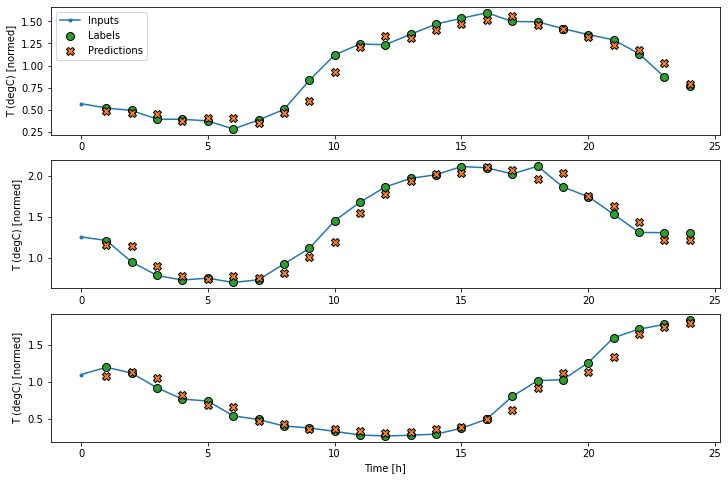

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

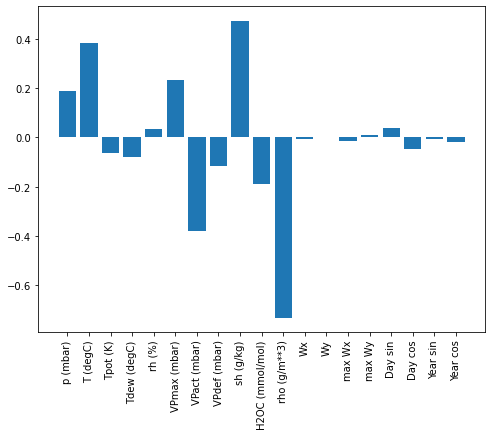

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 0s - loss: 1.2013 - mean_absolute_error: 0.8871

  18/1534 [..............................] - ETA: 4s - loss: 0.3691 - mean_absolute_error: 0.4450

  36/1534 [..............................] - ETA: 4s - loss: 0.2133 - mean_absolute_error: 0.3139

  53/1534 [>.............................] - ETA: 4s - loss: 0.1541 - mean_absolute_error: 0.2544

  70/1534 [>.............................] - ETA: 4s - loss: 0.1212 - mean_absolute_error: 0.2183

  85/1534 [>.............................] - ETA: 4s - loss: 0.1022 - mean_absolute_error: 0.1955

 102/1534 [>.............................] - ETA: 4s - loss: 0.0876 - mean_absolute_error: 0.1781

 119/1534 [=>............................] - ETA: 4s - loss: 0.0770 - mean_absolute_error: 0.1653

 137/1534 [=>............................] - ETA: 4s - loss: 0.0687 - mean_absolute_error: 0.1553

 155/1534 [==>...........................] - ETA: 4s - loss: 0.0621 - mean_absolute_error: 0.1470

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0574 - mean_absolute_error: 0.1414

 190/1534 [==>...........................] - ETA: 4s - loss: 0.0532 - mean_absolute_error: 0.1361

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0498 - mean_absolute_error: 0.1320

 224/1534 [===>..........................] - ETA: 3s - loss: 0.0470 - mean_absolute_error: 0.1284

 242/1534 [===>..........................] - ETA: 3s - loss: 0.0442 - mean_absolute_error: 0.1247

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0419 - mean_absolute_error: 0.1215

 278/1534 [====>.........................] - ETA: 3s - loss: 0.0399 - mean_absolute_error: 0.1188

 296/1534 [====>.........................] - ETA: 3s - loss: 0.0381 - mean_absolute_error: 0.1160

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0367 - mean_absolute_error: 0.1139

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0353 - mean_absolute_error: 0.1119

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0341 - mean_absolute_error: 0.1102

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0329 - mean_absolute_error: 0.1084

 383/1534 [======>.......................] - ETA: 3s - loss: 0.0317 - mean_absolute_error: 0.1066

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0308 - mean_absolute_error: 0.1052

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0299 - mean_absolute_error: 0.1038

 435/1534 [=======>......................] - ETA: 3s - loss: 0.0290 - mean_absolute_error: 0.1024

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0283 - mean_absolute_error: 0.1012

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0276 - mean_absolute_error: 0.1002

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0269 - mean_absolute_error: 0.0989

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0263 - mean_absolute_error: 0.0981

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0258 - mean_absolute_error: 0.0973

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0253 - mean_absolute_error: 0.0966

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0249 - mean_absolute_error: 0.0960

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0244 - mean_absolute_error: 0.0952

 591/1534 [==========>...................] - ETA: 2s - loss: 0.0239 - mean_absolute_error: 0.0945

 608/1534 [==========>...................] - ETA: 2s - loss: 0.0235 - mean_absolute_error: 0.0938

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0231 - mean_absolute_error: 0.0931

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0227 - mean_absolute_error: 0.0925

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0223 - mean_absolute_error: 0.0918

 681/1534 [============>.................] - ETA: 2s - loss: 0.0220 - mean_absolute_error: 0.0913

 698/1534 [============>.................] - ETA: 2s - loss: 0.0217 - mean_absolute_error: 0.0908

 715/1534 [============>.................] - ETA: 2s - loss: 0.0214 - mean_absolute_error: 0.0902

 732/1534 [=============>................] - ETA: 2s - loss: 0.0210 - mean_absolute_error: 0.0896

 749/1534 [=============>................] - ETA: 2s - loss: 0.0208 - mean_absolute_error: 0.0891

 766/1534 [=============>................] - ETA: 2s - loss: 0.0205 - mean_absolute_error: 0.0887

 784/1534 [==============>...............] - ETA: 2s - loss: 0.0202 - mean_absolute_error: 0.0882

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0200 - mean_absolute_error: 0.0877

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0197 - mean_absolute_error: 0.0872

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0195 - mean_absolute_error: 0.0869

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0193 - mean_absolute_error: 0.0865

 870/1534 [================>.............] - ETA: 1s - loss: 0.0190 - mean_absolute_error: 0.0861

 888/1534 [================>.............] - ETA: 1s - loss: 0.0188 - mean_absolute_error: 0.0858

 906/1534 [================>.............] - ETA: 1s - loss: 0.0187 - mean_absolute_error: 0.0855

 924/1534 [=================>............] - ETA: 1s - loss: 0.0185 - mean_absolute_error: 0.0853

 942/1534 [=================>............] - ETA: 1s - loss: 0.0183 - mean_absolute_error: 0.0849

 960/1534 [=================>............] - ETA: 1s - loss: 0.0181 - mean_absolute_error: 0.0846

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0180 - mean_absolute_error: 0.0844

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0178 - mean_absolute_error: 0.0842

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0177 - mean_absolute_error: 0.0839

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0175 - mean_absolute_error: 0.0836

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0174 - mean_absolute_error: 0.0834

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0172 - mean_absolute_error: 0.0832

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0171 - mean_absolute_error: 0.0829

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0169 - mean_absolute_error: 0.0826

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0168 - mean_absolute_error: 0.0824

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0167 - mean_absolute_error: 0.0822

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0820

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0164 - mean_absolute_error: 0.0817

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0163 - mean_absolute_error: 0.0815

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0814

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0811

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0810

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0808

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0807

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0805

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0803

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0801

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0799

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0798

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0797

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0795

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0793

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0791

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0790

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0789

1484/1534 [============================>.] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0787

1501/1534 [============================>.] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0785

1518/1534 [============================>.] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0784

1534/1534 [==============================] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0783

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0146 - mean_absolute_error: 0.0783 - val_loss: 0.0082 - val_mean_absolute_error: 0.0660


Epoch 2/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0735

  19/1534 [..............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0642

  36/1534 [..............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0652

  52/1534 [>.............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0645

  69/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0647

  86/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0656

 104/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0652

 122/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0652

 140/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0654

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0657

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0658

 192/1534 [==>...........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0661

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0659

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0659

 242/1534 [===>..........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0656

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0653

 275/1534 [====>.........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0653

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0652

 310/1534 [=====>........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 328/1534 [=====>........................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0652

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 361/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0652

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0652

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0651

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0650

 445/1534 [=======>......................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0649

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0649

 479/1534 [========>.....................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0650

 496/1534 [========>.....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0648

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0649

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0650

 548/1534 [=========>....................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0651

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0651

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0651

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0651

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0649

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 666/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 684/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0650

 702/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0649

 720/1534 [=============>................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0649

 737/1534 [=============>................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0647

 754/1534 [=============>................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0646

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0645

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0645

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0643

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0643

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0643

 857/1534 [===============>..............] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0643

 875/1534 [================>.............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0642

 893/1534 [================>.............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0642

 911/1534 [================>.............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0643

 929/1534 [=================>............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0642

 947/1534 [=================>............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0642

 964/1534 [=================>............] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0643

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0643

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1033/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0645

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0644

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0643

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0643

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0643

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0643

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0643

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0643

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0642

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0641

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0640

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0639

1498/1534 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0638

1515/1534 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0638

1529/1534 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0638

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0078 - mean_absolute_error: 0.0638 - val_loss: 0.0071 - val_mean_absolute_error: 0.0600


Epoch 3/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0736

  17/1534 [..............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0576

  34/1534 [..............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0596

  51/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0604

  68/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0606

  86/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0613

 103/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0617

 119/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0619

 137/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0626

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0629

 171/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0633

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0635

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0636

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0637

 243/1534 [===>..........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0635

 277/1534 [====>.........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0629

 382/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 399/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0633

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 451/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0629

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0630

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0632

 572/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0633

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 622/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0631

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0630

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 675/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 693/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 711/1534 [============>.................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 728/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0627

 746/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0625

 763/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0623

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0622

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0622

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0622

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0622

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

 885/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

 903/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

 921/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

 939/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

 957/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0622

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0622

1165/1534 [=====================>........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0621

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0622

1201/1534 [======================>.......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1219/1534 [======================>.......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1487/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0619

1505/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0619

1523/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0619

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0619 - val_loss: 0.0070 - val_mean_absolute_error: 0.0596


Epoch 4/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0478

  19/1534 [..............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0586

  37/1534 [..............................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0584

  55/1534 [>.............................] - ETA: 4s - loss: 0.0063 - mean_absolute_error: 0.0580

  73/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0591

  91/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0587

 109/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0586

 127/1534 [=>............................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0594

 145/1534 [=>............................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0596

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0604

 180/1534 [==>...........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 197/1534 [==>...........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0611

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 246/1534 [===>..........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 263/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 280/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0611

 297/1534 [====>.........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 315/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 333/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0609

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0610

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0607

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0607

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0607

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0609

 505/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0608

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0609

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 611/1534 [==========>...................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 682/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 700/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0610

 718/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 736/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0608

 753/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0607

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0606

 788/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0605

 824/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0606

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0606

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

 876/1534 [================>.............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

 893/1534 [================>.............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

 911/1534 [================>.............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

 928/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

 946/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

 964/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1122/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0607

1175/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1193/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1228/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1280/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1474/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1492/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1510/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1526/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0606 - val_loss: 0.0066 - val_mean_absolute_error: 0.0573


Epoch 5/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0526

  19/1534 [..............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0578

  37/1534 [..............................] - ETA: 4s - loss: 0.0061 - mean_absolute_error: 0.0576

  55/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

  74/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

  93/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 111/1534 [=>............................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0592

 128/1534 [=>............................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0594

 146/1534 [=>............................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0594

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0595

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0598

 200/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0602

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 289/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 306/1534 [====>.........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 324/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 360/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0598

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 413/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 448/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 482/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0599

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 535/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 570/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0600

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0600

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0597

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 679/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 696/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 713/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 731/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 749/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 767/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 857/1534 [===============>..............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 875/1534 [================>.............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0593

 893/1534 [================>.............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 911/1534 [================>.............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 929/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

 948/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 966/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1184/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1202/1534 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1490/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1508/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1525/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0598 - val_loss: 0.0072 - val_mean_absolute_error: 0.0618


Epoch 6/20
   1/1534 [..............................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0652

  19/1534 [..............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0589

  37/1534 [..............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0583

  56/1534 [>.............................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0583

  74/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

  92/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0591

 110/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0589

 128/1534 [=>............................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0588

 146/1534 [=>............................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0588

 164/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 182/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 201/1534 [==>...........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 237/1534 [===>..........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 290/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 345/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0589

 397/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 414/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0593

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0594

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0597

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0597

 612/1534 [==========>...................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 665/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 683/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 700/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 718/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0595

 736/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 755/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 788/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 824/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 842/1534 [===============>..............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

 877/1534 [================>.............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

 894/1534 [================>.............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

 911/1534 [================>.............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

 928/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0591

 945/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

 962/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0592

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1160/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1248/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0591

1484/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1502/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1520/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0070 - val_mean_absolute_error: 0.0610


  1/439 [..............................] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

 21/439 [>.............................] - ETA: 1s - loss: 0.0064 - mean_absolute_error: 0.0596

 41/439 [=>............................] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0607

 61/439 [===>..........................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0608

 82/439 [====>.........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0600

103/439 [======>.......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0602

124/439 [=======>......................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0603

145/439 [========>.....................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0603

166/439 [==========>...................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0606

187/439 [===========>..................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0603

207/439 [=============>................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0606

228/439 [==============>...............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0603

249/439 [================>.............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0605

270/439 [=================>............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0606

291/439 [==================>...........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0607

312/439 [====================>.........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0609

332/439 [=====================>........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0610

352/439 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0608

372/439 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0608

393/439 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0608

414/439 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0609

432/439 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0609

439/439 [==============================] - 1s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0610


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

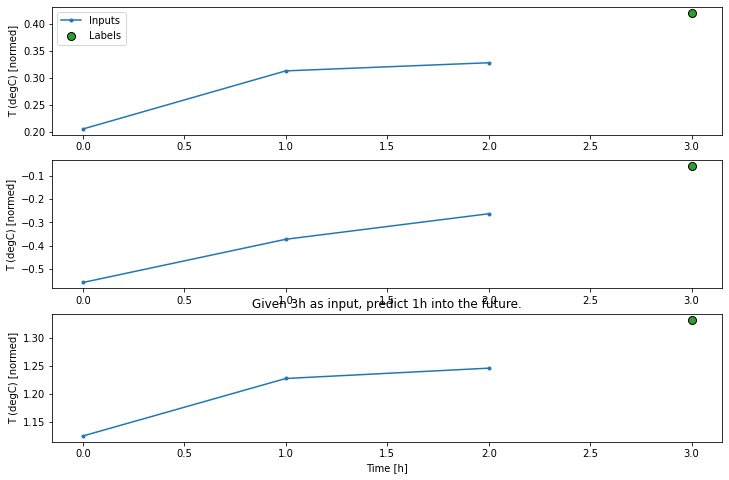

In [48]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0709

 26/438 [>.............................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0602

 52/438 [==>...........................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0594

 77/438 [====>.........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0598

104/438 [======>.......................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0598

131/438 [=======>......................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0594

158/438 [=========>....................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0597

186/438 [===========>..................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0597

213/438 [=============>................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0598

240/438 [===============>..............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0600

267/438 [=================>............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0602

294/438 [===================>..........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0602

322/438 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0599

348/438 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0599

375/438 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

402/438 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

429/438 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

438/438 [==============================] - 1s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0601


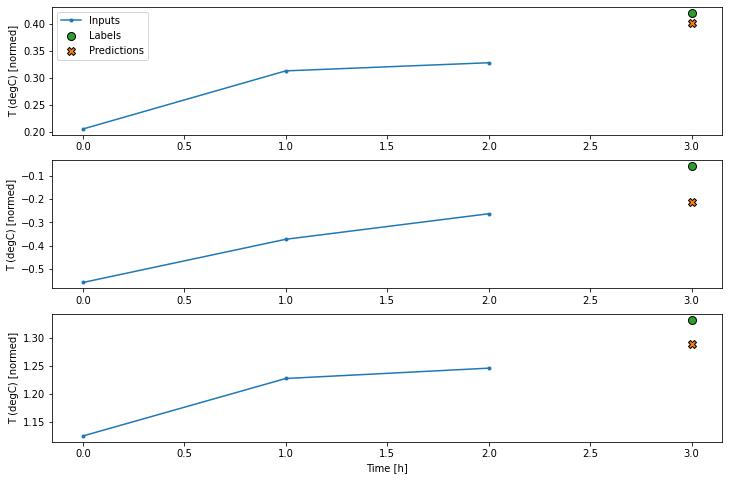

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,456], In[1]: [57,32] [Op:MatMul]


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0552

 18/438 [>.............................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0545

 36/438 [=>............................] - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.0562

 55/438 [==>...........................] - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.0555

 73/438 [====>.........................] - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.0555

 90/438 [=====>........................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0552

107/438 [======>.......................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0555

124/438 [=======>......................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0555

142/438 [========>.....................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0554

160/438 [=========>....................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0555

177/438 [===========>..................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0553

194/438 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0556

212/438 [=============>................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

230/438 [==============>...............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0558

247/438 [===============>..............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0558

265/438 [=================>............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0560

282/438 [==================>...........] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0558

300/438 [===================>..........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

318/438 [====================>.........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

336/438 [======================>.......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

354/438 [=======================>......] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0562

371/438 [========================>.....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

389/438 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0560

406/438 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

423/438 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0559

438/438 [==============================] - 1s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0558


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

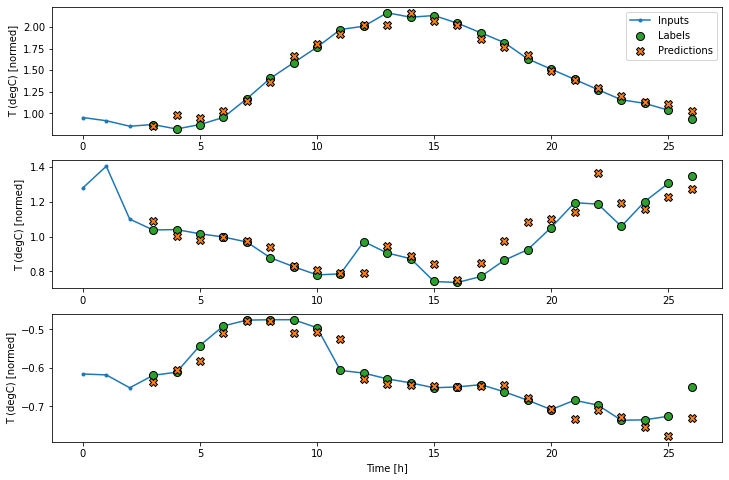

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0533

 19/438 [>.............................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0524

 37/438 [=>............................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0527

 54/438 [==>...........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0518

 71/438 [===>..........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0520

 89/438 [=====>........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0519

107/438 [======>.......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

125/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

144/438 [========>.....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

162/438 [==========>...................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

180/438 [===========>..................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0512

199/438 [============>.................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0513

217/438 [=============>................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

235/438 [===============>..............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0513

253/438 [================>.............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0513

271/438 [=================>............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0512

290/438 [==================>...........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0513

308/438 [====================>.........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

325/438 [=====================>........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

344/438 [======================>.......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

362/438 [=======================>......] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

380/438 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

397/438 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0515

414/438 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

431/438 [============================>.] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

438/438 [==============================] - 1s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0514


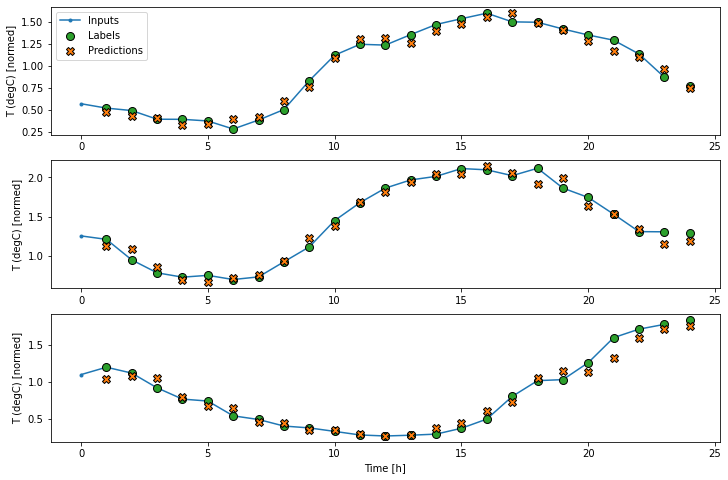

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

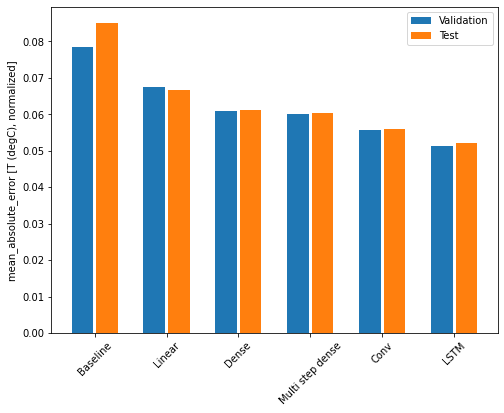

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0666
Dense       : 0.0612
Multi step dense: 0.0604
Conv        : 0.0561
LSTM        : 0.0521


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 0s - loss: 0.1169 - mean_absolute_error: 0.1806

 27/438 [>.............................] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.1588

 53/438 [==>...........................] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1584

 80/438 [====>.........................] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1580

107/438 [======>.......................] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1587

132/438 [========>.....................] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.1592

159/438 [=========>....................] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.1592

186/438 [===========>..................] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.1594

211/438 [=============>................] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1591

239/438 [===============>..............] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1591

265/438 [=================>............] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

292/438 [===================>..........] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

319/438 [====================>.........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

345/438 [======================>.......] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

371/438 [========================>.....] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

398/438 [==========================>...] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1589

424/438 [============================>.] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 0s - loss: 0.0884 - mean_absolute_error: 0.1491

 21/439 [>.............................] - ETA: 1s - loss: 0.0662 - mean_absolute_error: 0.1303

 42/439 [=>............................] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1303

 62/439 [===>..........................] - ETA: 0s - loss: 0.0667 - mean_absolute_error: 0.1296

 82/439 [====>.........................] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1302

102/439 [=====>........................] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1303

121/439 [=======>......................] - ETA: 0s - loss: 0.0673 - mean_absolute_error: 0.1303

141/439 [========>.....................] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.1305

161/439 [==========>...................] - ETA: 0s - loss: 0.0673 - mean_absolute_error: 0.1304

181/439 [===========>..................] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.1299

200/439 [============>.................] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.1303

220/439 [==============>...............] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1309

240/439 [===============>..............] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1309

259/439 [================>.............] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1312

277/439 [=================>............] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1311

298/439 [===================>..........] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1313

318/439 [====================>.........] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1312

338/439 [======================>.......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1311

358/439 [=======================>......] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1312

377/439 [========================>.....] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1310

397/439 [==========================>...] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1310

416/439 [===========================>..] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1309

433/439 [============================>.] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1308

439/439 [==============================] - 1s 3ms/step - loss: 0.0680 - mean_absolute_error: 0.1308


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.1332

 18/438 [>.............................] - ETA: 1s - loss: 0.0630 - mean_absolute_error: 0.1221

 36/438 [=>............................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1223

 54/438 [==>...........................] - ETA: 1s - loss: 0.0632 - mean_absolute_error: 0.1226

 72/438 [===>..........................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1222

 90/438 [=====>........................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1220

107/438 [======>.......................] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1219

125/438 [=======>......................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1216

143/438 [========>.....................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1214

161/438 [==========>...................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1212

179/438 [===========>..................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1212

198/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1211

216/438 [=============>................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1209

234/438 [===============>..............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1210

252/438 [================>.............] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1209

271/438 [=================>............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1210

290/438 [==================>...........] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1210

309/438 [====================>.........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1209

327/438 [=====================>........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1208

346/438 [======================>.......] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1207

364/438 [=======================>......] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1208

382/438 [=========================>....] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1207

401/438 [==========================>...] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1208

419/438 [===========================>..] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1207

436/438 [============================>.] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1207

438/438 [==============================] - 1s 3ms/step - loss: 0.0615 - mean_absolute_error: 0.1207



CPU times: user 4min 12s, sys: 1min 5s, total: 5min 17s
Wall time: 1min 56s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict the how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 0s - loss: 0.0668 - mean_absolute_error: 0.1214

 16/438 [>.............................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1183

 33/438 [=>............................] - ETA: 1s - loss: 0.0629 - mean_absolute_error: 0.1189

 49/438 [==>...........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1180

 66/438 [===>..........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1180

 82/438 [====>.........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1180

 98/438 [=====>........................] - ETA: 1s - loss: 0.0617 - mean_absolute_error: 0.1177

114/438 [======>.......................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1178

130/438 [=======>......................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1179

146/438 [=========>....................] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1182

163/438 [==========>...................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1180

179/438 [===========>..................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1179

195/438 [============>.................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

211/438 [=============>................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

227/438 [==============>...............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

243/438 [===============>..............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1179

259/438 [================>.............] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1178

276/438 [=================>............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1176

292/438 [===================>..........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

308/438 [====================>.........] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

325/438 [=====================>........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

342/438 [======================>.......] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1177

359/438 [=======================>......] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

375/438 [========================>.....] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1177

391/438 [=========================>....] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

408/438 [==========================>...] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

423/438 [===========================>..] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1176

438/438 [==============================] - 1s 3ms/step - loss: 0.0620 - mean_absolute_error: 0.1176



CPU times: user 1min 28s, sys: 22.8 s, total: 1min 51s
Wall time: 41.7 s


#### Performance

Here is the overall performance for these multi-output models.

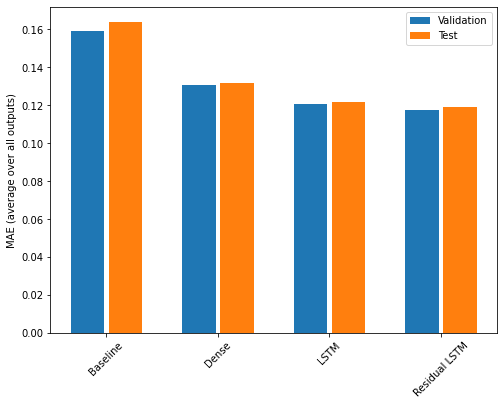

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1316
LSTM           : 0.1220
Residual LSTM  : 0.1193


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

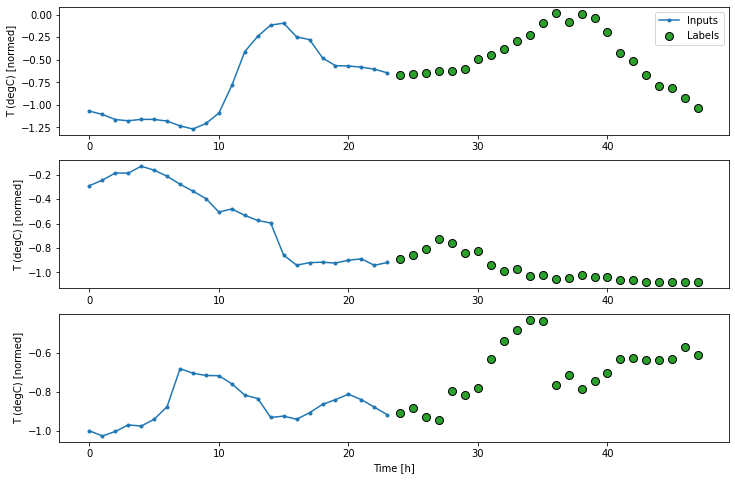

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 0s - loss: 0.5755 - mean_absolute_error: 0.4694

 24/437 [>.............................] - ETA: 0s - loss: 0.6251 - mean_absolute_error: 0.5015

 49/437 [==>...........................] - ETA: 0s - loss: 0.6343 - mean_absolute_error: 0.5026

 75/437 [====>.........................] - ETA: 0s - loss: 0.6275 - mean_absolute_error: 0.5012

100/437 [=====>........................] - ETA: 0s - loss: 0.6263 - mean_absolute_error: 0.5000

125/437 [=======>......................] - ETA: 0s - loss: 0.6275 - mean_absolute_error: 0.5005

149/437 [=========>....................] - ETA: 0s - loss: 0.6286 - mean_absolute_error: 0.5006

172/437 [==========>...................] - ETA: 0s - loss: 0.6301 - mean_absolute_error: 0.5004

196/437 [============>.................] - ETA: 0s - loss: 0.6332 - mean_absolute_error: 0.5022

220/437 [==============>...............] - ETA: 0s - loss: 0.6296 - mean_absolute_error: 0.5007

244/437 [===============>..............] - ETA: 0s - loss: 0.6300 - mean_absolute_error: 0.5012

265/437 [=================>............] - ETA: 0s - loss: 0.6283 - mean_absolute_error: 0.5007

287/437 [==================>...........] - ETA: 0s - loss: 0.6272 - mean_absolute_error: 0.5003

307/437 [====================>.........] - ETA: 0s - loss: 0.6275 - mean_absolute_error: 0.5003

329/437 [=====================>........] - ETA: 0s - loss: 0.6288 - mean_absolute_error: 0.5007

352/437 [=======================>......] - ETA: 0s - loss: 0.6295 - mean_absolute_error: 0.5008

377/437 [========================>.....] - ETA: 0s - loss: 0.6286 - mean_absolute_error: 0.5004

401/437 [==========================>...] - ETA: 0s - loss: 0.6284 - mean_absolute_error: 0.5006

426/437 [============================>.] - ETA: 0s - loss: 0.6289 - mean_absolute_error: 0.5009

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


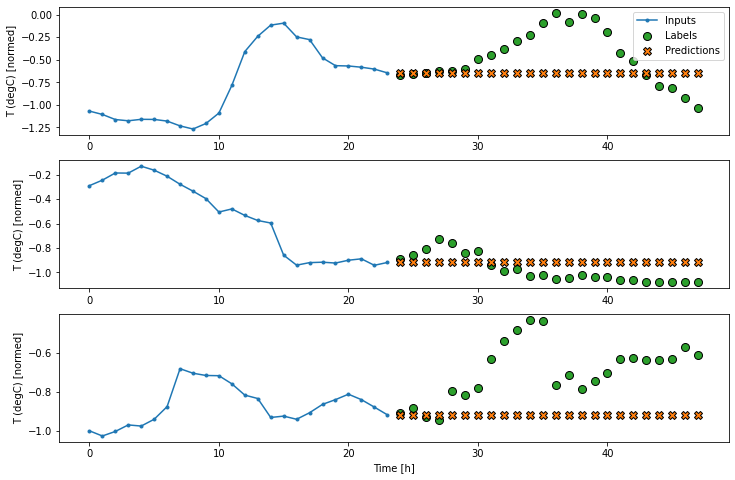

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 0s - loss: 0.3869 - mean_absolute_error: 0.3731

 25/437 [>.............................] - ETA: 0s - loss: 0.4252 - mean_absolute_error: 0.3925

 50/437 [==>...........................] - ETA: 0s - loss: 0.4243 - mean_absolute_error: 0.3958

 75/437 [====>.........................] - ETA: 0s - loss: 0.4240 - mean_absolute_error: 0.3962

100/437 [=====>........................] - ETA: 0s - loss: 0.4197 - mean_absolute_error: 0.3942

126/437 [=======>......................] - ETA: 0s - loss: 0.4214 - mean_absolute_error: 0.3944

152/437 [=========>....................] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.3946

178/437 [===========>..................] - ETA: 0s - loss: 0.4222 - mean_absolute_error: 0.3943

203/437 [============>.................] - ETA: 0s - loss: 0.4236 - mean_absolute_error: 0.3947

228/437 [==============>...............] - ETA: 0s - loss: 0.4258 - mean_absolute_error: 0.3957

254/437 [================>.............] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3958

280/437 [==================>...........] - ETA: 0s - loss: 0.4279 - mean_absolute_error: 0.3964

305/437 [===================>..........] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3963

331/437 [=====================>........] - ETA: 0s - loss: 0.4275 - mean_absolute_error: 0.3961

358/437 [=======================>......] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.3959

383/437 [=========================>....] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3958

407/437 [==========================>...] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3957

431/437 [============================>.] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3958

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


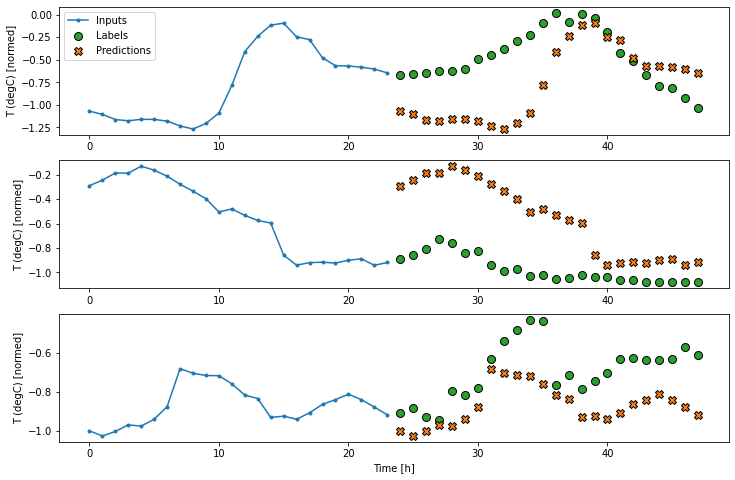

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 0s - loss: 0.2428 - mean_absolute_error: 0.2915

 24/437 [>.............................] - ETA: 0s - loss: 0.2495 - mean_absolute_error: 0.3025

 48/437 [==>...........................] - ETA: 0s - loss: 0.2525 - mean_absolute_error: 0.3044

 72/437 [===>..........................] - ETA: 0s - loss: 0.2530 - mean_absolute_error: 0.3041

 94/437 [=====>........................] - ETA: 0s - loss: 0.2536 - mean_absolute_error: 0.3045

117/437 [=======>......................] - ETA: 0s - loss: 0.2559 - mean_absolute_error: 0.3055

141/437 [========>.....................] - ETA: 0s - loss: 0.2531 - mean_absolute_error: 0.3042

163/437 [==========>...................] - ETA: 0s - loss: 0.2542 - mean_absolute_error: 0.3049

186/437 [===========>..................] - ETA: 0s - loss: 0.2542 - mean_absolute_error: 0.3051

209/437 [=============>................] - ETA: 0s - loss: 0.2545 - mean_absolute_error: 0.3053

231/437 [==============>...............] - ETA: 0s - loss: 0.2543 - mean_absolute_error: 0.3052

254/437 [================>.............] - ETA: 0s - loss: 0.2541 - mean_absolute_error: 0.3052

277/437 [==================>...........] - ETA: 0s - loss: 0.2543 - mean_absolute_error: 0.3053

301/437 [===================>..........] - ETA: 0s - loss: 0.2539 - mean_absolute_error: 0.3052

325/437 [=====================>........] - ETA: 0s - loss: 0.2549 - mean_absolute_error: 0.3056

349/437 [======================>.......] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3057

372/437 [========================>.....] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3058

396/437 [==========================>...] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3060

418/437 [===========================>..] - ETA: 0s - loss: 0.2555 - mean_absolute_error: 0.3061

437/437 [==============================] - 1s 2ms/step - loss: 0.2554 - mean_absolute_error: 0.3059


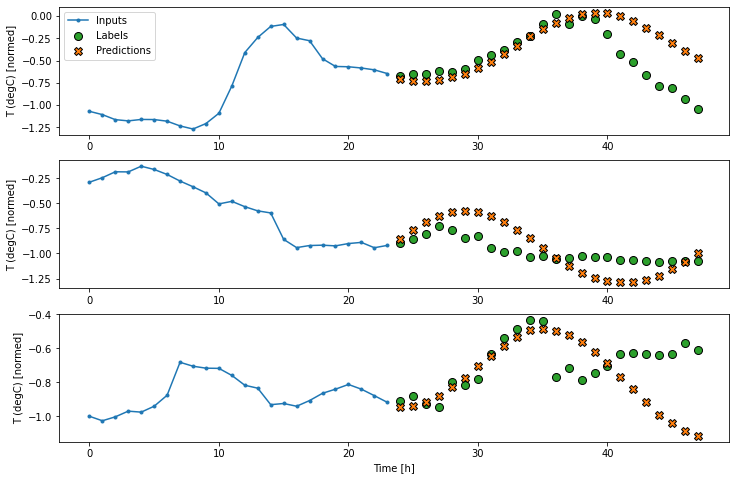

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

  1/437 [..............................] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2761

 22/437 [>.............................] - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.2804

 44/437 [==>...........................] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2818

 65/437 [===>..........................] - ETA: 0s - loss: 0.2210 - mean_absolute_error: 0.2832

 86/437 [====>.........................] - ETA: 0s - loss: 0.2228 - mean_absolute_error: 0.2839

108/437 [======>.......................] - ETA: 0s - loss: 0.2227 - mean_absolute_error: 0.2833

130/437 [=======>......................] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2825

151/437 [=========>....................] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2830

172/437 [==========>...................] - ETA: 0s - loss: 0.2220 - mean_absolute_error: 0.2827

193/437 [============>.................] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2817

214/437 [=============>................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2812

235/437 [===============>..............] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2814

256/437 [================>.............] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2813

277/437 [==================>...........] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2812

298/437 [===================>..........] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2808

319/437 [====================>.........] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2808

340/437 [======================>.......] - ETA: 0s - loss: 0.2181 - mean_absolute_error: 0.2807

361/437 [=======================>......] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2809

382/437 [=========================>....] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2809

404/437 [==========================>...] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2808

425/437 [============================>.] - ETA: 0s - loss: 0.2176 - mean_absolute_error: 0.2806

437/437 [==============================] - 1s 2ms/step - loss: 0.2177 - mean_absolute_error: 0.2807


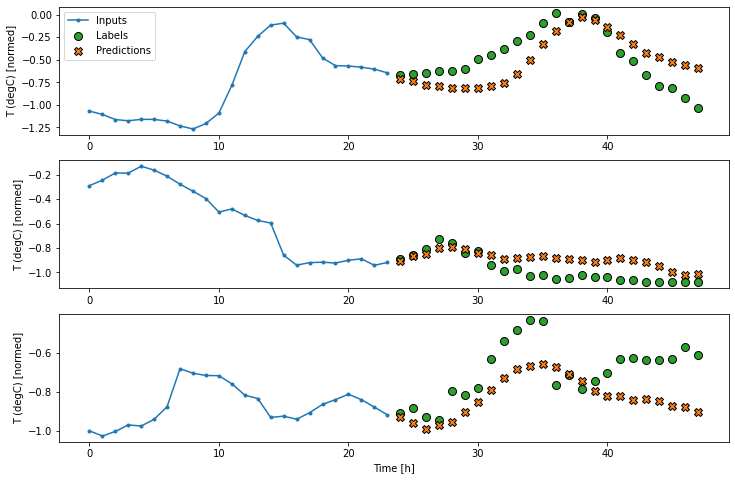

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 0s - loss: 0.2033 - mean_absolute_error: 0.2693

 23/437 [>.............................] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.2810

 46/437 [==>...........................] - ETA: 0s - loss: 0.2091 - mean_absolute_error: 0.2789

 67/437 [===>..........................] - ETA: 0s - loss: 0.2083 - mean_absolute_error: 0.2788

 88/437 [=====>........................] - ETA: 0s - loss: 0.2079 - mean_absolute_error: 0.2773

110/437 [======>.......................] - ETA: 0s - loss: 0.2076 - mean_absolute_error: 0.2776

131/437 [=======>......................] - ETA: 0s - loss: 0.2078 - mean_absolute_error: 0.2776

151/437 [=========>....................] - ETA: 0s - loss: 0.2103 - mean_absolute_error: 0.2788

172/437 [==========>...................] - ETA: 0s - loss: 0.2104 - mean_absolute_error: 0.2789

192/437 [============>.................] - ETA: 0s - loss: 0.2113 - mean_absolute_error: 0.2793

213/437 [=============>................] - ETA: 0s - loss: 0.2122 - mean_absolute_error: 0.2796

234/437 [===============>..............] - ETA: 0s - loss: 0.2131 - mean_absolute_error: 0.2801

254/437 [================>.............] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2807

274/437 [=================>............] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2809

296/437 [===================>..........] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2806

318/437 [====================>.........] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2806

340/437 [======================>.......] - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.2801

363/437 [=======================>......] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2806

385/437 [=========================>....] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2807

406/437 [==========================>...] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2809

429/437 [============================>.] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2811

437/437 [==============================] - 1s 2ms/step - loss: 0.2141 - mean_absolute_error: 0.2810


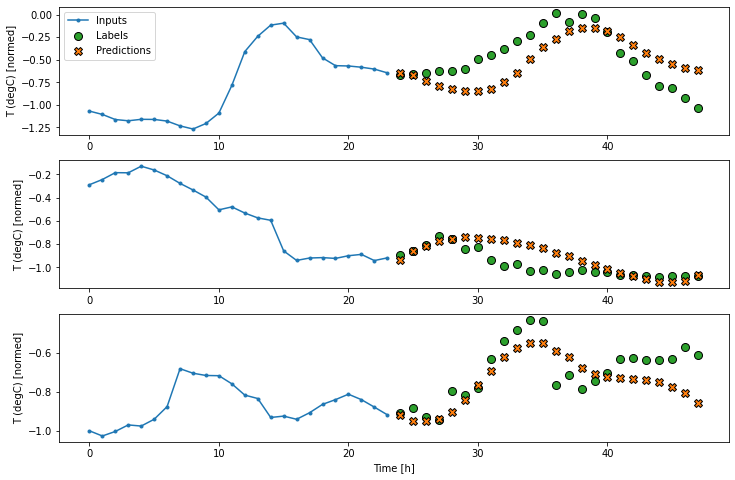

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 0s - loss: 0.2383 - mean_absolute_error: 0.3066

 20/437 [>.............................] - ETA: 1s - loss: 0.2307 - mean_absolute_error: 0.2942

 40/437 [=>............................] - ETA: 1s - loss: 0.2199 - mean_absolute_error: 0.2872

 58/437 [==>...........................] - ETA: 1s - loss: 0.2191 - mean_absolute_error: 0.2862

 76/437 [====>.........................] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2855

 94/437 [=====>........................] - ETA: 0s - loss: 0.2177 - mean_absolute_error: 0.2854

112/437 [======>.......................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2852

130/437 [=======>......................] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2856

149/437 [=========>....................] - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.2856

168/437 [==========>...................] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2860

187/437 [===========>..................] - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.2858

207/437 [=============>................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2855

227/437 [==============>...............] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2850

247/437 [===============>..............] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2849

266/437 [=================>............] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2852

286/437 [==================>...........] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2853

305/437 [===================>..........] - ETA: 0s - loss: 0.2161 - mean_absolute_error: 0.2852

324/437 [=====================>........] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2850

344/437 [======================>.......] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2852

364/437 [=======================>......] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2850

384/437 [=========================>....] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2850

404/437 [==========================>...] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2848

424/437 [============================>.] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2847

437/437 [==============================] - 1s 3ms/step - loss: 0.2153 - mean_absolute_error: 0.2847


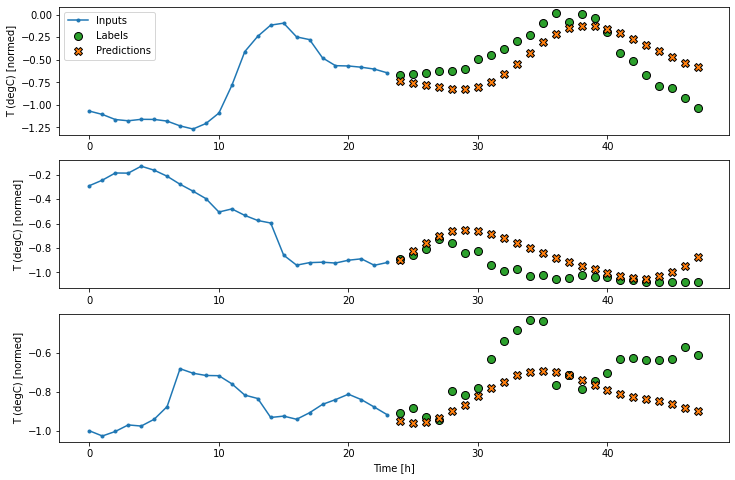

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence as a in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of single single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

  1/437 [..............................] - ETA: 0s - loss: 0.2303 - mean_absolute_error: 0.3042

  9/437 [..............................] - ETA: 2s - loss: 0.2375 - mean_absolute_error: 0.3091

 17/437 [>.............................] - ETA: 2s - loss: 0.2281 - mean_absolute_error: 0.3026

 25/437 [>.............................] - ETA: 2s - loss: 0.2265 - mean_absolute_error: 0.3011

 33/437 [=>............................] - ETA: 2s - loss: 0.2243 - mean_absolute_error: 0.2986

 41/437 [=>............................] - ETA: 2s - loss: 0.2225 - mean_absolute_error: 0.2966

 49/437 [==>...........................] - ETA: 2s - loss: 0.2224 - mean_absolute_error: 0.2966

 57/437 [==>...........................] - ETA: 2s - loss: 0.2219 - mean_absolute_error: 0.2968

 65/437 [===>..........................] - ETA: 2s - loss: 0.2225 - mean_absolute_error: 0.2968

 73/437 [====>.........................] - ETA: 2s - loss: 0.2238 - mean_absolute_error: 0.2976

 81/437 [====>.........................] - ETA: 2s - loss: 0.2233 - mean_absolute_error: 0.2969

 89/437 [=====>........................] - ETA: 2s - loss: 0.2222 - mean_absolute_error: 0.2965

 97/437 [=====>........................] - ETA: 2s - loss: 0.2233 - mean_absolute_error: 0.2970

105/437 [======>.......................] - ETA: 2s - loss: 0.2221 - mean_absolute_error: 0.2962

113/437 [======>.......................] - ETA: 2s - loss: 0.2223 - mean_absolute_error: 0.2964

121/437 [=======>......................] - ETA: 2s - loss: 0.2220 - mean_absolute_error: 0.2961

129/437 [=======>......................] - ETA: 2s - loss: 0.2217 - mean_absolute_error: 0.2960

137/437 [========>.....................] - ETA: 1s - loss: 0.2217 - mean_absolute_error: 0.2960

144/437 [========>.....................] - ETA: 1s - loss: 0.2211 - mean_absolute_error: 0.2958

152/437 [=========>....................] - ETA: 1s - loss: 0.2217 - mean_absolute_error: 0.2963

160/437 [=========>....................] - ETA: 1s - loss: 0.2214 - mean_absolute_error: 0.2962

167/437 [==========>...................] - ETA: 1s - loss: 0.2212 - mean_absolute_error: 0.2961

174/437 [==========>...................] - ETA: 1s - loss: 0.2210 - mean_absolute_error: 0.2960

181/437 [===========>..................] - ETA: 1s - loss: 0.2210 - mean_absolute_error: 0.2959

189/437 [===========>..................] - ETA: 1s - loss: 0.2208 - mean_absolute_error: 0.2958

197/437 [============>.................] - ETA: 1s - loss: 0.2208 - mean_absolute_error: 0.2957

205/437 [=============>................] - ETA: 1s - loss: 0.2212 - mean_absolute_error: 0.2958

212/437 [=============>................] - ETA: 1s - loss: 0.2211 - mean_absolute_error: 0.2959

220/437 [==============>...............] - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.2961

228/437 [==============>...............] - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.2961

236/437 [===============>..............] - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.2961

243/437 [===============>..............] - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.2961

251/437 [================>.............] - ETA: 1s - loss: 0.2213 - mean_absolute_error: 0.2958

258/437 [================>.............] - ETA: 1s - loss: 0.2214 - mean_absolute_error: 0.2959

266/437 [=================>............] - ETA: 1s - loss: 0.2210 - mean_absolute_error: 0.2957

274/437 [=================>............] - ETA: 1s - loss: 0.2209 - mean_absolute_error: 0.2957

282/437 [==================>...........] - ETA: 1s - loss: 0.2208 - mean_absolute_error: 0.2957

290/437 [==================>...........] - ETA: 0s - loss: 0.2207 - mean_absolute_error: 0.2956

299/437 [===================>..........] - ETA: 0s - loss: 0.2204 - mean_absolute_error: 0.2955

307/437 [====================>.........] - ETA: 0s - loss: 0.2206 - mean_absolute_error: 0.2956

315/437 [====================>.........] - ETA: 0s - loss: 0.2210 - mean_absolute_error: 0.2959

322/437 [=====================>........] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2960

330/437 [=====================>........] - ETA: 0s - loss: 0.2216 - mean_absolute_error: 0.2961

339/437 [======================>.......] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2960

347/437 [======================>.......] - ETA: 0s - loss: 0.2215 - mean_absolute_error: 0.2960

355/437 [=======================>......] - ETA: 0s - loss: 0.2213 - mean_absolute_error: 0.2960

364/437 [=======================>......] - ETA: 0s - loss: 0.2218 - mean_absolute_error: 0.2963

372/437 [========================>.....] - ETA: 0s - loss: 0.2219 - mean_absolute_error: 0.2964

380/437 [=========================>....] - ETA: 0s - loss: 0.2219 - mean_absolute_error: 0.2965

387/437 [=========================>....] - ETA: 0s - loss: 0.2220 - mean_absolute_error: 0.2965

395/437 [==========================>...] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2967

403/437 [==========================>...] - ETA: 0s - loss: 0.2227 - mean_absolute_error: 0.2968

411/437 [===========================>..] - ETA: 0s - loss: 0.2226 - mean_absolute_error: 0.2968

420/437 [===========================>..] - ETA: 0s - loss: 0.2227 - mean_absolute_error: 0.2970

428/437 [============================>.] - ETA: 0s - loss: 0.2230 - mean_absolute_error: 0.2972

436/437 [============================>.] - ETA: 0s - loss: 0.2230 - mean_absolute_error: 0.2972

437/437 [==============================] - 3s 7ms/step - loss: 0.2231 - mean_absolute_error: 0.2972


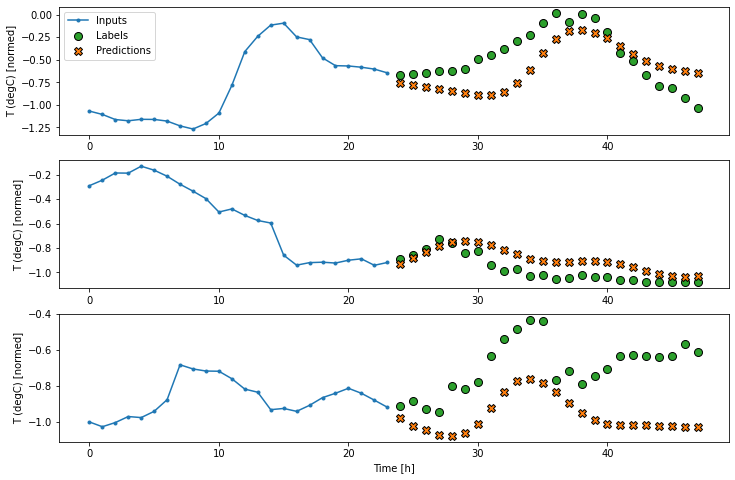

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

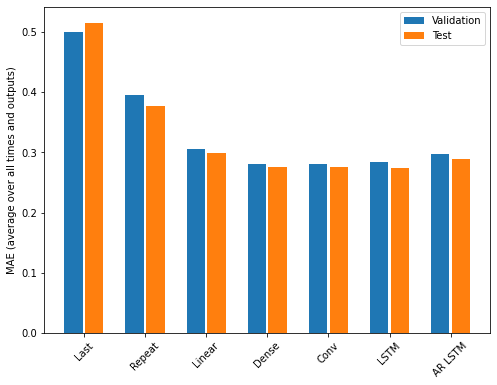

In [91]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2991
Dense   : 0.2762
Conv    : 0.2756
LSTM    : 0.2741
AR LSTM : 0.2897


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.